In [1]:
# dependencies

import datetime

import numpy as np
import pandas as pd
import pystan as stan
import matplotlib.pyplot as plt
import seaborn as sns

import nfx.lm.gibbs
import nfx.misc.plot

In [5]:
# helper functions

def package_sla_samples(samples, node_names, covariate_names):

    coef_samples, prec_samples, nuisance_samples = zip(*sla_samples)
    coef_samples = [np.array(coef_samples_) for coef_samples_ in zip(*coef_samples)][::-1]
    prec_samples = np.trace(prec_samples, axis1=2, axis2=3).T[::-1]
    nuisance_samples = np.array(nuisance_samples).T
    return package_coef_samples(coef_samples, node_names, covariate_names, 'SLA'), package_prec_samples(prec_samples, 'SLA'), package_nuisance_samples(nuisance_samples, node_names[-1], 'SLA')

def package_nuts_samples(samples, node_names, covariate_names):

    coef_samples = [s[:, 0] for s in [samples[par] for par in ('loc_0', 'loc_1', 'loc_2', 'loc_3', 'coefs')]]
    coef_samples[0] = coef_samples[0][:, np.newaxis]
    prec_samples = np.array([[np.trace(np.linalg.inv(tau__[0])) for tau__ in tau_] for tau_ in [nuts_samples[par] for par in ('cov_1', 'cov_2', 'cov_3', 'cov_4')]])
    nuisance_samples = 1 / samples['var_resid'][:, 0].T
    return package_coef_samples(coef_samples, node_names, covariate_names, 'Stan/NUTS'), package_prec_samples(prec_samples, 'Stan/NUTS'), package_nuisance_samples(nuisance_samples, node_names[-1], 'Stan/NUTS')

def package_coef_samples(coef_samples, node_names, covariate_names, algo_name):

    dfs = []
    for i, (coef_samples_, node_names_) in enumerate(zip(coef_samples, node_names)):
        for j, node_names__ in enumerate(node_names_):
            df_ = pd.DataFrame(coef_samples_[:, j].T, index=covariate_names)
            df_.index = df_.index.rename('covariate')
            df_.columns = df_.columns.rename('iter')
            df_['algo'] = algo_name
            df_['level'] = i
            df_['node'] = node_names__.zfill(i + 1)
            dfs.append(df_)
    df = pd.concat(dfs).reset_index().set_index(['algo', 'level', 'node', 'covariate'])
    return df

def package_prec_samples(prec_samples, algo_name):

    df = pd.DataFrame(prec_samples, index=np.arange(len(prec_samples)))
    df.index = df.index.rename('level')
    df.columns = df.columns.rename('iter')
    df['algo'] = algo_name
    df = df.reset_index().set_index(['algo', 'level'])
    return df

def package_nuisance_samples(nuisance_samples, node_names, algo_name):

    df = pd.DataFrame(np.mean(nuisance_samples, 0)[np.newaxis], index=['mean'])
    df.index = df.index.rename('node')
    df.columns = df.columns.rename('iter')
    df['algo'] = algo_name
    df = df.reset_index().set_index(['algo', 'node'])
    return df
        
def est_acf(samples, n_lags):

    acf = samples.apply(lambda x: nfx.misc.plot.est_acf(x.values, n_lags), 1, False, 'expand')
    acf.columns = acf.columns.rename('lag')
    return acf

def est_ess(acfs, titer):
    
    df = pd.DataFrame(index=acfs.index)
    df['iat[iter]'] = acfs.apply(lambda x: nfx.misc.plot.est_int_autocor(x.values), 1, False, 'expand').rename('iat')
    df['iat[sec]'] = df['iat[iter]'] * titer
    df['rate[iter]'] = 1 / (2 * df['iat[iter]'])
    df['rate[sec]'] = df['rate[iter]'] / titer
    return df

In [6]:
# config

covariate_names = ['housing']
seed = 0

In [7]:
# load data

macro = pd.read_csv('paper/data/sareb_covariates.csv').set_index('time')
prices = pd.read_csv('paper/data/sareb_prices_synthetic.csv').set_index('zip')
rng = np.random.default_rng(seed)

In [8]:
# format response

response = prices.diff(axis=1).dropna(axis=1)

In [9]:
# format covariates

covariates = macro.loc[:, covariate_names]
covariates['_constant'] = 1
covariates['_trend'] = np.arange(covariates.shape[0])
covariates = covariates.loc[:, ['_trend', 'housing']].diff().dropna().loc[response.columns]

In [10]:
# construct tree

indices = response.index.to_frame()
indices['lvl_1'] = indices.zip.str.slice(0, 2)
indices['lvl_2'] = indices.zip.str.slice(0, 3)
indices['lvl_3'] = indices.zip.str.slice(0, 4)
indices['lvl_4'] = indices.zip.str.slice(0, 5)
indices = indices.drop('zip', 1)
codes = indices.apply(lambda x: x.astype('category').cat.codes).astype('int64')
n_nodes = codes.max(0) + 1
parent_node_3 = codes[['lvl_4', 'lvl_3']].drop_duplicates().lvl_3
parent_node_2 = codes[['lvl_3', 'lvl_2']].drop_duplicates().lvl_2
parent_node_1 = codes[['lvl_2', 'lvl_1']].drop_duplicates().lvl_1
tree = [parent_node_3, parent_node_2, parent_node_1]
node_names = [['0'], indices.lvl_1.unique(), indices.lvl_2.unique(), indices.lvl_3.unique(), indices.lvl_4.unique()]

/tmp/ipykernel_289998/2691591494.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  indices = indices.drop('zip', 1)


In [11]:
# assemble nuts inputs

nuts_inputs = {
    'n_periods': response.shape[1],
    'n_leaves': response.shape[0],
    'n_covariates': covariates.shape[1],
    'n_nodes_3': parent_node_3.max() + 1,
    'n_nodes_2': parent_node_2.max() + 1,
    'n_nodes_1': parent_node_1.max() + 1,
    'parent_node_3': parent_node_3.values + 1,
    'parent_node_2': parent_node_2.values + 1,
    'parent_node_1': parent_node_1.values + 1,
    'covariates': covariates.values.T,
    'response': response.values,
    'prior_df': covariates.shape[1],
    'prior_shape': 1/2,
    'prior_rate': 1/2
}

In [ ]:
# sample nuts

nuts_n_samples = 1000
stan_model = stan.StanModel('paper/stan/nfx_panel_normal.stan')
t0 = datetime.datetime.now()
stan_sampler = stan_model.sampling(data=nuts_inputs, iter=2*nuts_n_samples, warmup=nuts_n_samples, chains=1, seed=0)
t1 = datetime.datetime.now()
nuts_titer = (t1 - t0).total_seconds() / nuts_n_samples
nuts_leaps = stan_sampler.get_sampler_params(inc_warmup=False)[0]['n_leapfrog__'].mean()
nuts_samples = stan_sampler.extract(['loc_0', 'loc_1', 'loc_2', 'loc_3', 'coefs', 'cov_1', 'cov_2', 'cov_3', 'cov_4', 'var_resid'], permuted=False)

In [12]:
# compute nuts summaries

nuts_coef_samples, nuts_prec_samples, nuts_nuisance_samples = package_nuts_samples(nuts_samples, node_names, ['_trend'] + covariate_names)
nuts_coef_acf, nuts_prec_acf, nuts_nuisance_acf = (est_acf(samples_, 64) for samples_ in (nuts_coef_samples, nuts_prec_samples, nuts_nuisance_samples))
nuts_coef_ess, nuts_prec_ess, nuts_nuisance_ess = (est_ess(acfs_, nuts_titer) for acfs_ in (nuts_coef_acf, nuts_prec_acf, nuts_nuisance_acf))

In [13]:
# construct sla inputs

sla_inputs = (response.values, covariates.values, tree)

In [14]:
# sample sla

sla_n_samples = 10000
sla_sampler = nfx.lm.gibbs.sample_posterior(*sla_inputs, ome=rng)
next(sla_sampler)
t0 = datetime.datetime.now()
sla_samples = [next(sla_sampler) for _ in  range(10 + sla_n_samples)][10:]
t1 = datetime.datetime.now()
sla_titer = (t1 - t0).total_seconds() / sla_n_samples

In [16]:
# compute sla summaries

sla_coef_samples, sla_prec_samples, sla_nuisance_samples = package_sla_samples(sla_samples, node_names, ['_trend'] + covariate_names)
sla_coef_acf, sla_prec_acf, sla_nuisance_acf = (est_acf(samples_, 256) for samples_ in (sla_coef_samples, sla_prec_samples, sla_nuisance_samples))
sla_coef_ess, sla_prec_ess, sla_nuisance_ess = (est_ess(acfs_, sla_titer) for acfs_ in (sla_coef_acf, sla_prec_acf, sla_nuisance_acf))

In [17]:
# stack

coef_acf = pd.concat([sla_coef_acf, nuts_coef_acf])
prec_acf = pd.concat([sla_prec_acf, nuts_prec_acf])
nuisance_acf = pd.concat([sla_nuisance_acf, nuts_nuisance_acf])
coef_ess = pd.concat([sla_coef_ess, nuts_coef_ess])
prec_ess = pd.concat([sla_prec_ess, nuts_prec_ess])
nuisance_ess = pd.concat([sla_nuisance_ess, nuts_nuisance_ess])

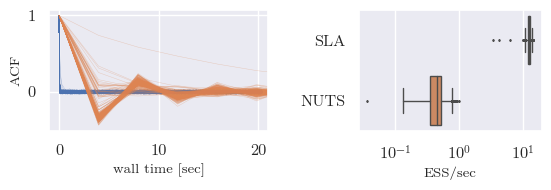

In [6]:
acf = pd.concat([coef_acf, prec_acf]).reset_index().set_index(['algo', 'level', 'node', 'covariate'])
iat = acf.apply(lambda x: nfx.misc.plot.est_int_autocor(x.values), 1, False, 'expand').rename('iat')
rank = iat.groupby(level='algo').rank(ascending=False)
#acf = acf.loc[(acf.columns.astype(float) < 10) | (acf.columns.astype(float) % 10 == 0)].reset_index()
acf = acf.loc[(rank < 20) | (rank % 20 == 0)].reset_index()
acf['param_ix'] = acf.index
acf_long = acf.melt(id_vars=['algo', 'level', 'node', 'covariate', 'param_ix'], var_name='iter_lag').dropna(subset=['value'])
acf_long['time_lag'] = acf_long.iter_lag.astype(float) * np.where(acf_long['algo'] == 'SLA', sla_titer, nuts_titer)
ess = pd.concat([coef_ess, prec_ess]).reset_index()
ess['node'] = ess.node.fillna(0)
ess = ess.replace('Stan/NUTS', 'NUTS')

f, axes = plt.subplots(1, 2, figsize=(2 * (8/5 + 4/3), 2), gridspec_kw={'width_ratios': [8/5, 4/3]})
g = sns.lineplot(data=acf_long, x='time_lag', y='value', hue='algo', style='param_ix', dashes=False, markers=False, legend=False, alpha=1/3, lw=1/3, ax=axes[0])
g.set(xlabel='wall time [sec]', ylabel='ACF', xlim=(-1, 21))
g = sns.boxplot(data=ess, y='algo', x='rate[sec]', order=['SLA', 'NUTS'], linewidth=1, fliersize=1, sym='o', orient='h', ax=axes[1])
g.set(ylabel='$\\quad$', xlabel='ESS/sec', xscale='log')